In [17]:
import torch
import torchvision

In [18]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [19]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [20]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [21]:
example_data.shape

torch.Size([1000, 1, 28, 28])

This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one)

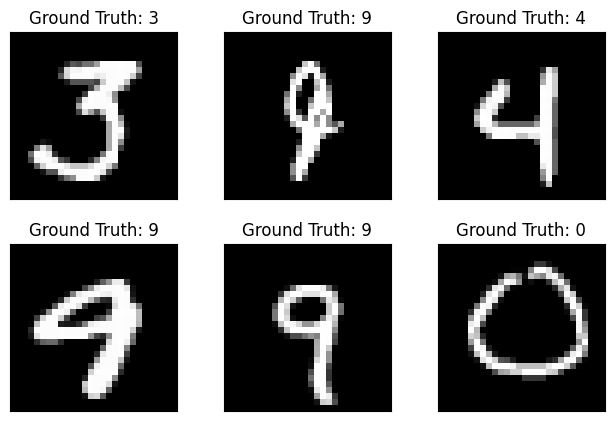

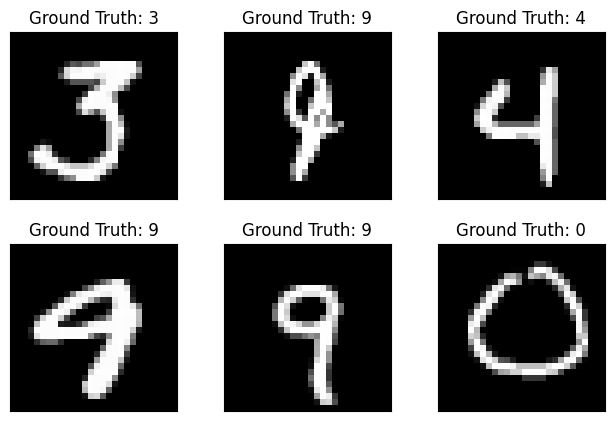

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Building the Network

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


Broadly speaking we can think of the torch.nn layers as which contain trainable parameters while torch.nn.functional are purely functional. The forward() pass defines the way we compute our output using the given layers and functions

In [25]:
## let's initialize the network and the optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Note: If we were using a GPU for training, we should have also sent the network parameters to the GPU using e.g. network.cuda(). It is important to transfer the network's parameters to the appropriate device before passing them to the optimizer, otherwise the optimizer will not be able to keep track of them in the right way.

## Training the Model

Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The backward() call we now collect a new set of gradients which we propagate back into each of the network's parameters using optimizer.step().

In [26]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [27]:
import os

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()
                )
            )

            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset))
            )

            # ✅ create and save correctly
            os.makedirs('results', exist_ok=True)
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')


Neural network modules as well as optimizers have the ability to save and load their internal state using .state_dict(). With this we can continue training from previously saved state dicts if needed - we'd just need to call .load_state_dict(state_dict).

In [28]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using the context manager no_grad() we can avoid storing the computations done producing the output of our network in the computation graph.

Time to run the training! We'll manually add a test() call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [29]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\Adio\AppData\Local\Temp\ipykernel_8932\461288150.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.181804
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.733285
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.313725
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.026400
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.007130
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.036813
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.809312
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.867944
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.693378
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.610975
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.561613
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.640599
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.520340
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.577988
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.868777
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.619951
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.688882
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.867956
Train Epoch: 1 [12160/6

# MNIST Training and Test Results Explained

This document clarifies the training logs and test results from your MNIST model, helping you understand what the numbers mean and why they change during training.

---

## Initial Test Results (Before Training)

When you first test the untrained model, you'll see something like:

- **Accuracy: ~9%**
- **Average Loss: ~2.30**

**What this means:** The model starts with randomly initialized weights and essentially guesses uniformly across all 10 digit classes. Since MNIST has 10 classes (digits 0-9), random guessing yields approximately 10% accuracy. The loss of ~2.30 comes from the Negative Log-Likelihood Loss calculation: log(1/10) ≈ -2.302.

This baseline confirms your model is untrained and behaving as expected before any learning occurs.

---

## Training Progress (Epoch 1)

As training begins, you'll see the loss decrease rapidly:

```
Train Epoch: 1 [0/60000 (0%)]      Loss: 2.325928
Train Epoch: 1 [1280/60000 (2%)]   Loss: 1.733285
Train Epoch: 1 [2560/60000 (4%)]   Loss: 1.026400
Train Epoch: 1 [6400/60000 (11%)]  Loss: 0.610975
```

**What's happening:** With each batch, the model performs these steps:

```python
output = network(data)
loss = F.nll_loss(output, target)
loss.backward()
optimizer.step()
```

The network processes a batch, calculates how wrong it was, computes gradients via backpropagation, and updates its weights. The dramatic loss reduction—from 2.33 to 0.61 in just the first epoch—shows the model rapidly learning fundamental features like edges, strokes, and basic digit shapes. This steep initial improvement is characteristic of MNIST's relative simplicity.

---

## Final Test Results (After Training)

After completing all training epochs:

- **Accuracy: ~98%** (9,822 out of 10,000 correct)
- **Average Loss: <0.10**

**What this means:** The model has learned to generalize well to unseen data. A 98% accuracy rate demonstrates strong performance on MNIST, while the very low loss indicates the model makes confident, correct predictions—assigning high probabilities to the right digit classes.